# Analyzing the selling price of used cars
Here we have the data of some cars and how much there were resold for. Our objective is to create a model which can predict the most optimal selling price of any other car.

Importing required libraries

In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
import xgboost
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.metrics import r2_score

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

## Data Preprocessing

In [2]:
df = pd.read_csv("data/output.csv")
df.head()

,Unnamed: 0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.00,111,5000,21,27,13495
0,0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,2,164,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,3,2,164,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,4,2,?,audi,gas,std,two,sedan,fwd,front,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


### Applying column names
Here we can see that the dataset has no columns but we have the name of the columns from place where we got the dataset. Let's apply them.

In [3]:
columns = [
    "symboling",
    "normalized-losses",
    "make",
    "fuel-type",
    "aspiration",
    "num-of-doors",
    "body-style",
    "drive-wheels",
    "engine-location",
    "wheel-base",
    "length",
    "width",
    "height",
    "curb-weight",
    "engine-type",
    "num-of-cylinders",
    "engine-size",
    "fuel-system",
    "bore",
    "stroke",
    "compression-ratio",
    "horsepower",
    "peak-rpm",
    "city-mpg",
    "highway-mpg",
    "price",
]

df = df.iloc[:, 1:]
df.columns = columns
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


### Handling missing values
Now we have a dataset with which we can do something. First step would be to handle missing values.

In [4]:
df.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

We can see that there is not a single missing value but looking at the dataset we can see that we have placeholders for missing values. Let's see the description of the dataset.

In [5]:
def transform_to_none(data):
    if data == "?":
        data = np.nan
    return data

In [6]:
for column in columns:
    df[column] = df[column].apply(transform_to_none)

In [7]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [8]:
df.isnull().sum()

symboling             0
normalized-losses    40
make                  0
fuel-type             0
aspiration            0
num-of-doors          2
body-style            0
drive-wheels          0
engine-location       0
wheel-base            0
length                0
width                 0
height                0
curb-weight           0
engine-type           0
num-of-cylinders      0
engine-size           0
fuel-system           0
bore                  4
stroke                4
compression-ratio     0
horsepower            2
peak-rpm              2
city-mpg              0
highway-mpg           0
price                 4
dtype: int64

Now we can see the proper null values. Let's deal with them using imputing.

In [9]:
def mean_impute(data):
    imp = SimpleImputer()
    return pd.Series(
        imp.fit_transform(data.values.reshape(-1, 1)).flatten(), index=data.index
    )


def mode_impute(data):
    imp = SimpleImputer(strategy="most_frequent")
    return pd.Series(
        imp.fit_transform(data.values.reshape(-1, 1)).flatten(), index=data.index
    )

In [10]:
for column in columns:
    df[column] = mode_impute(df[column])

df.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

We used mode imputing to deal with missing values.

Convert strings which should be numbers

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    int64  
 1   normalized-losses  204 non-null    object 
 2   make               204 non-null    object 
 3   fuel-type          204 non-null    object 
 4   aspiration         204 non-null    object 
 5   num-of-doors       204 non-null    object 
 6   body-style         204 non-null    object 
 7   drive-wheels       204 non-null    object 
 8   engine-location    204 non-null    object 
 9   wheel-base         204 non-null    float64
 10  length             204 non-null    float64
 11  width              204 non-null    float64
 12  height             204 non-null    float64
 13  curb-weight        204 non-null    int64  
 14  engine-type        204 non-null    object 
 15  num-of-cylinders   204 non-null    object 
 16  engine-size        204 non

It is also quiet clear that some data types should be float or integer but are tagged as object instead. Let's fix that.

In [12]:
should_be_numerical = [
    "normalized-losses",
    "bore",
    "stroke",
    "horsepower",
    "peak-rpm",
    "price",
]
for column in should_be_numerical:
    df[column] = pd.to_numeric(df[column])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    int64  
 1   normalized-losses  204 non-null    int64  
 2   make               204 non-null    object 
 3   fuel-type          204 non-null    object 
 4   aspiration         204 non-null    object 
 5   num-of-doors       204 non-null    object 
 6   body-style         204 non-null    object 
 7   drive-wheels       204 non-null    object 
 8   engine-location    204 non-null    object 
 9   wheel-base         204 non-null    float64
 10  length             204 non-null    float64
 11  width              204 non-null    float64
 12  height             204 non-null    float64
 13  curb-weight        204 non-null    int64  
 14  engine-type        204 non-null    object 
 15  num-of-cylinders   204 non-null    object 
 16  engine-size        204 non

### Label Encoding
It is quiet apparent that we have lots of data in string format but as our models can not deal with them we need to encode them.

In [13]:
pre_encode = df.copy()
lab_enc = OrdinalEncoder()
for column in columns:
    if df[column].dtype in ["object"]:
        temp_df = pd.DataFrame(df[column])
        df[column] = lab_enc.fit_transform(temp_df)

df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,161,0.0,1.0,0.0,1.0,0.0,2.0,0.0,88.6,...,130,5.0,3.47,2.68,9.0,111,5000,21,27,16500
1,1,161,0.0,1.0,0.0,1.0,2.0,2.0,0.0,94.5,...,152,5.0,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,1.0,1.0,0.0,0.0,3.0,1.0,0.0,99.8,...,109,5.0,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,1.0,1.0,0.0,0.0,3.0,0.0,0.0,99.4,...,136,5.0,3.19,3.40,8.0,115,5500,18,22,17450
4,2,161,1.0,1.0,0.0,1.0,3.0,1.0,0.0,99.8,...,136,5.0,3.19,3.40,8.5,110,5500,19,25,15250


### Scaling
Now that we have a numerical data, let's make their scale similar for better accuracy down the lane.

In [14]:
scaler = StandardScaler()
columns = [
    "normalized-losses",
    "wheel-base",
    "length",
    "width",
    "height",
    "curb-weight",
    "engine-size",
    "horsepower",
    "peak-rpm",
    "city-mpg",
    "highway-mpg",
]
df_scaled = df
for column in columns:
    df_scaled[column] = pd.Series(
        scaler.fit_transform(df_scaled[column].values.reshape(-1, 1)).flatten()
    )
df_scaled.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,0.889130,0.0,1.0,0.0,1.0,0.0,2.0,0.0,-1.706913,...,0.074632,5.0,3.47,2.68,9.0,0.179759,-0.271067,-0.648801,-0.547796,16500
1,1,0.889130,0.0,1.0,0.0,1.0,2.0,2.0,0.0,-0.720197,...,0.602943,5.0,2.68,3.47,9.0,1.263505,-0.271067,-0.954825,-0.693115,16500
2,2,0.974206,1.0,1.0,0.0,0.0,3.0,1.0,0.0,0.166174,...,-0.429665,5.0,3.19,3.40,10.0,-0.047071,0.774259,-0.189765,-0.111839,13950
3,2,0.974206,1.0,1.0,0.0,0.0,3.0,0.0,0.0,0.099278,...,0.218717,5.0,3.19,3.40,8.0,0.280573,0.774259,-1.107837,-1.274391,17450
4,2,0.889130,1.0,1.0,0.0,1.0,3.0,1.0,0.0,0.166174,...,0.218717,5.0,3.19,3.40,8.5,0.154556,0.774259,-0.954825,-0.838434,15250


## EDA
Now we have a scaled data so let's do some EDA.

In [15]:
corr = df_scaled.corr()
print(corr)

                   symboling  normalized-losses      make  fuel-type  \
symboling           1.000000           0.443281 -0.103884   0.192995   
normalized-losses   0.443281           1.000000 -0.313255   0.071497   
make               -0.103884          -0.313255  1.000000  -0.111119   
fuel-type           0.192995           0.071497 -0.111119   1.000000   
aspiration         -0.056306           0.018420  0.050280  -0.400964   
num-of-doors        0.660879           0.351993 -0.142395   0.187304   
body-style         -0.587925          -0.244289  0.062365  -0.146351   
drive-wheels       -0.052623           0.388647  0.007366  -0.134736   
engine-location     0.215129           0.108624  0.053951   0.040278   
wheel-base         -0.525095           0.044378  0.063392  -0.307866   
length             -0.356792           0.149684  0.116652  -0.212142   
width              -0.227799           0.207762 -0.004333  -0.232988   
height             -0.533078          -0.345763  0.221208  -0.28

In [16]:
corr["price"].sort_values()

highway-mpg         -0.690584
city-mpg            -0.667787
make                -0.163254
fuel-type           -0.110054
peak-rpm            -0.103465
symboling           -0.083326
body-style          -0.073942
num-of-doors        -0.041817
num-of-cylinders     0.004618
compression-ratio    0.070855
engine-type          0.073172
stroke               0.082554
height               0.135480
aspiration           0.177592
normalized-losses    0.317553
engine-location      0.330955
fuel-system          0.517242
bore                 0.526105
drive-wheels         0.578310
wheel-base           0.587345
length               0.682910
width                0.730439
horsepower           0.759762
curb-weight          0.820812
engine-size          0.861770
price                1.000000
Name: price, dtype: float64

We can clearly see the correlation of each column and price. Let's separate the important ones from unimportant ones.

In [17]:
imp_column = []
for column in corr["price"].index:
    if abs(corr["price"][column]) >= 0.3:
        imp_column.append(column)
print(imp_column)

['normalized-losses', 'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'curb-weight', 'engine-size', 'fuel-system', 'bore', 'horsepower', 'city-mpg', 'highway-mpg', 'price']


In [18]:
df_imp = df_scaled[imp_column]
df_imp.head()

,normalized-losses,drive-wheels,engine-location,wheel-base,length,width,curb-weight,engine-size,fuel-system,bore,horsepower,city-mpg,highway-mpg,price
0,0.889130,2.0,0.0,-1.706913,-0.427756,-0.848336,-0.014602,0.074632,5.0,3.47,0.179759,-0.648801,-0.547796,16500
1,0.889130,2.0,0.0,-0.720197,-0.233137,-0.194572,0.513554,0.602943,5.0,2.68,1.263505,-0.954825,-0.693115,16500
2,0.974206,1.0,0.0,0.166174,0.204755,0.132309,-0.419841,-0.429665,5.0,3.19,-0.047071,-0.189765,-0.111839,13950
3,0.974206,0.0,0.0,0.099278,0.204755,0.225704,0.515474,0.218717,5.0,3.19,0.280573,-1.107837,-1.274391,17450
4,0.889130,1.0,0.0,0.166174,0.261519,0.179007,-0.093345,0.218717,5.0,3.19,0.154556,-0.954825,-0.838434,15250


Now we have important columns. Let's plot some graphs.

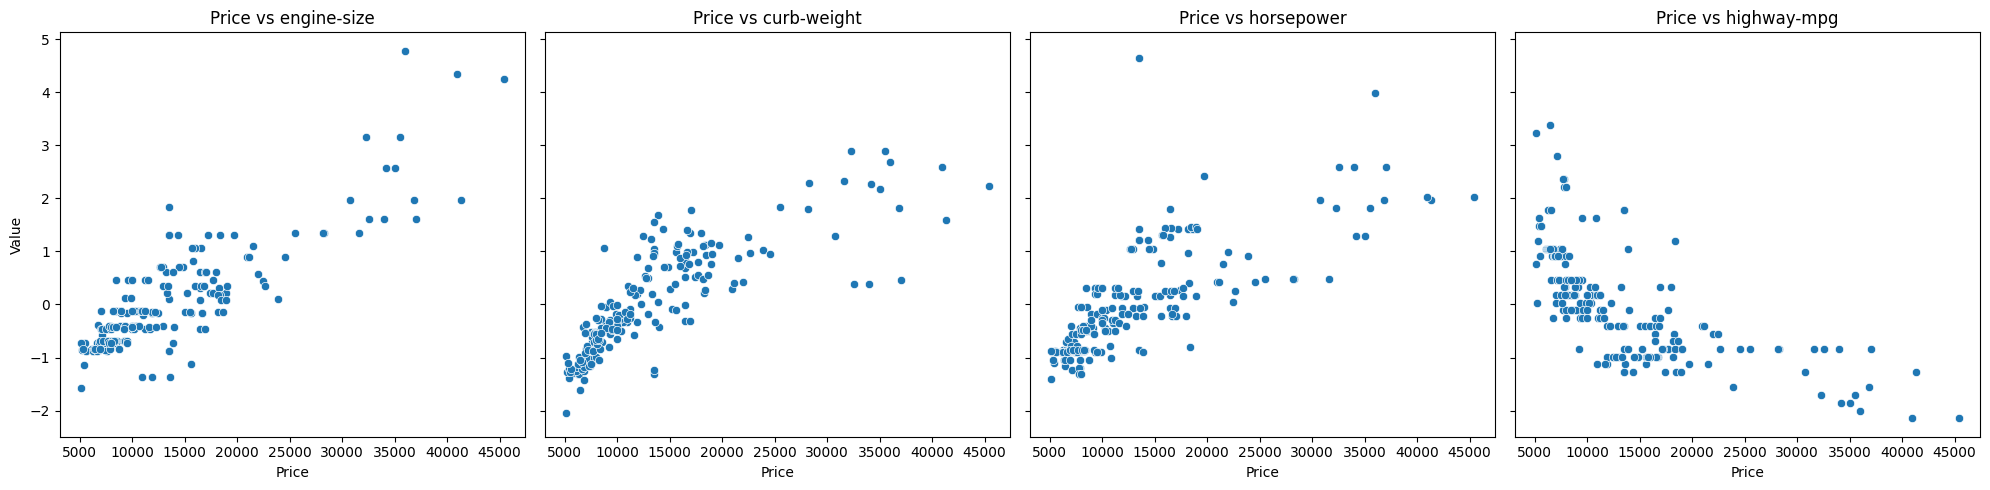

In [19]:
features = ["engine-size", "curb-weight", "horsepower", "highway-mpg"]
fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
for i, feature in enumerate(features):
    sns.scatterplot(ax=axes[i], x=df_imp["price"], y=df_imp[feature])
    axes[i].set_title(f"Price vs {feature}")
    axes[i].set_xlabel("Price")
    if i == 0:
        axes[i].set_ylabel("Value")
    else:
        axes[i].set_ylabel(None)


plt.tight_layout()
plt.show()

From the above graphs we can see the relation of price with some columns.

## Models
As this is a regression problem, let's try some regression algorithms and measure their accuracy.

In [20]:
X = df_imp.iloc[:, :-1]
y = df_imp.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, train_size=0.8
)

### Linear Regression
First let's try linear regression

In [21]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin_reg = lin_reg.predict(X_test)
print(r2_score(y_test, y_pred_lin_reg))

0.7145133336981817


### Bagging Regressor
Bagging ensemble method for regression

In [22]:
bag_reg = BaggingRegressor()
bag_reg.fit(X_train, y_train)
y_pred_bag_reg = bag_reg.predict(X_test)
print(r2_score(y_test, y_pred_bag_reg))

0.7153645080943667


### Adaboost Regressor
Boosting ensemble method for regression

In [23]:
ada_reg = AdaBoostRegressor()
ada_reg.fit(X_train, y_train)
y_pred_ada_reg = ada_reg.predict(X_test)
print(r2_score(y_test, y_pred_ada_reg))

0.7348342906834389


### XGBoost
Using XGBoost Regressor

In [24]:
xgb_reg = xgboost.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    seed=42,
)
xgb_reg.fit(X_train, y_train)
y_pred_xgb_reg = xgb_reg.predict(X_test)
print(r2_score(y_test, y_pred_xgb_reg))

0.661073625087738


We maintain an accuracy of 65% to 75%. This is because of lack of data.

## Hyperparameter Tuning
We will tune the hyperparameter to get the best possible parameters for optimal performance.

In [25]:
xg_params = {
    "objective": ["reg:squarederror"],
    "n_estimators": np.arange(50, 150),
    "learning_rate": np.linspace(0.01, 1.0),
    "max_depth": np.arange(1, 5),
    "seed": np.arange(1, 50),
}

xgb_rcv = xgboost.XGBRegressor()
xgb_cv = RandomizedSearchCV(xgb_rcv, xg_params, cv=10)
xgb_cv.fit(X_train, y_train)

best_params = xgb_cv.best_params_
print("Tuned Decision Tree Parameters: {}".format(best_params))
print("Best score is {}".format(xgb_cv.best_score_))

Tuned Decision Tree Parameters: {'seed': np.int64(35), 'objective': 'reg:squarederror', 'n_estimators': np.int64(116), 'max_depth': np.int64(2), 'learning_rate': np.float64(0.333265306122449)}
Best score is 0.8542721331119537


/home/anish/Documents/work/internship_mobcoder/training/project-used-cars/venv/lib64/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [26]:
xgb_reg = xgboost.XGBRegressor(**best_params)
xgb_reg.fit(X_train, y_train)
y_pred_xgb_reg = xgb_reg.predict(X_test)
print(r2_score(y_test, y_pred_xgb_reg))

0.628158688545227


In [27]:
ada_params = {
    "n_estimators": [80, 100, 120, 140, 160],
    "learning_rate": [0.001, 0.01, 0.1, 1],
    "loss": ["linear", "square", "exponential"],
}
ada_reg = AdaBoostRegressor()
ada_cv = RandomizedSearchCV(ada_reg, ada_params, cv=10)
ada_cv.fit(X_train, y_train)

best_params = ada_cv.best_params_
print("Tuned Decision Tree Parameters: {}".format(best_params))
print("Best score is {}".format(ada_cv.best_score_))

Tuned Decision Tree Parameters: {'n_estimators': 160, 'loss': 'linear', 'learning_rate': 0.1}
Best score is 0.8291321684421338


In [28]:
ada_reg = AdaBoostRegressor(**best_params)
ada_reg.fit(X_train, y_train)
y_pred_ada_reg = ada_reg.predict(X_test)
print(r2_score(y_test, y_pred_ada_reg))

0.71706017723562


Final step is to serialize the model with highest accuracy. Let's also create a pipeline for preprocessing.

In [29]:
joblib.dump(ada_reg, "model.joblib")

['model.joblib']

In [30]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            "cat",
            Pipeline(
                steps=[
                    (
                        "imputer",
                        SimpleImputer(strategy="most_frequent"),
                    ),
                    ("encoder", OrdinalEncoder()),
                ]
            ),
            selector(dtype_include=["object", "category"]),
        ),
        (
            "num",
            Pipeline(
                steps=[
                    (
                        "imputer",
                        SimpleImputer(strategy="mean"),
                    ),
                    ("scaler", StandardScaler()),
                ]
            ),
            selector(dtype_include=["int64", "float64"]),
        ),
    ],
    remainder="passthrough",
)

In [31]:
pipe = Pipeline(
    steps=[
        ("Preprocessor", preprocessor),
    ]
)

In [32]:
pipe.fit(pre_encode[X.columns])

Pipeline(steps=[('Preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa6873620>),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f6aa5d08690>)]))])

In [33]:
joblib.dump(pipe, "preprocess_pipeline.joblib")

['preprocess_pipeline.joblib']